# Fit Convergent Cross Mapping Model to Data Sets

In [1]:
import pandas as pd
import numpy as np
import skccm as ccm
import matplotlib.pyplot as plt
import seaborn as sns
from skccm.utilities import train_test_split
from teaspoon.parameter_selection.FNN_n import FNN_n

In [232]:
data = pd.read_csv('./data/merged_data.csv',index_col=0)
data = data.sort_values(by=['year','month'],ascending=[True, True])
#data = data[data['USstate']=='ar']
data = data.groupby(['year','month']).sum()
data

misogyny_proportion  alcohol_counts  crime_counts  \
year month                                                      
2012 1                 0.000129           82.83          41.0   
     2                 0.000042           82.83          46.0   
     3                 0.000041           82.83          47.0   
     4                 0.000117           82.83          46.0   
     5                 0.000122           82.83          63.0   
     6                 0.000027           82.83          47.0   
     7                 0.000037           82.83          65.0   
     8                 0.000060           82.83          52.0   
     11                0.000020           82.83          29.0   
     12                0.000048           82.83          40.0   
2013 3                 0.000044           87.82          44.0   
     4                 0.000031           87.82          47.0   
     7                 0.000026           87.82          82.0   
     8                 0.000025           87.82          59.0   
     9                 0.000029           87.82          53.0   
     11                0.000029           87.82          35.0   
2014 6                 0.000020           89.55          50.0   
2015 4                 0.000164           93.05         120.0   
     6                 0.000045           93.05          92.0   
     10                0.000047           93.05         107.0   

            crime_proportion  
year month                    
2012 1              0.000053  
     2              0.000070  
     3              0.000071  
     4              0.000077  
     5              0.000071  
     6              0.000052  
     7              0.000072  
     8              0.000066  
     11             0.000056  
     12             0.000050  
2013 3              0.000072  
     4              0.000049  
     7              0.000056  
     8              0.000063  
     9              0.000068  
     11             0.000061  
2014 6              0.000050  
2015 4              0.000070  
     6              0.000075  
     10             0.000069

## 0. Extract data

In [228]:
x1_alcohol = data['alcohol_counts'].to_numpy()
x2_crime = data['crime_proportion'].to_numpy()
x3_tweets = data['misogyny_proportion'].to_numpy()

In [229]:
corr = data.corr() #reference correlation
corr

,misogyny_proportion,alcohol_counts,crime_counts,crime_proportion
misogyny_proportion,1.000000,0.326170,-0.216416,0.441486
alcohol_counts,0.326170,1.000000,0.065419,0.770040
crime_counts,-0.216416,0.065419,1.000000,0.289340
crime_proportion,0.441486,0.770040,0.289340,1.000000


# Alcohol vs Crime

## 1. Calculate Mutual information

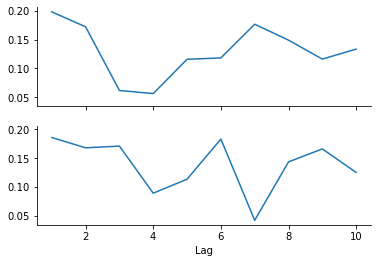

In [212]:
e1 = ccm.Embed(x1_alcohol)
e2 = ccm.Embed(x2_crime)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

## 2. Embed the time series

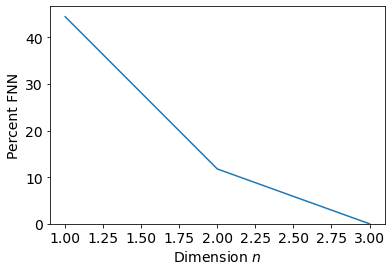

FNN embedding Dimension 2:  3


In [213]:
lag = 2
perc_FNN2, embed = FNN_n(x2, lag, plotting = True)
print('FNN embedding Dimension 2: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

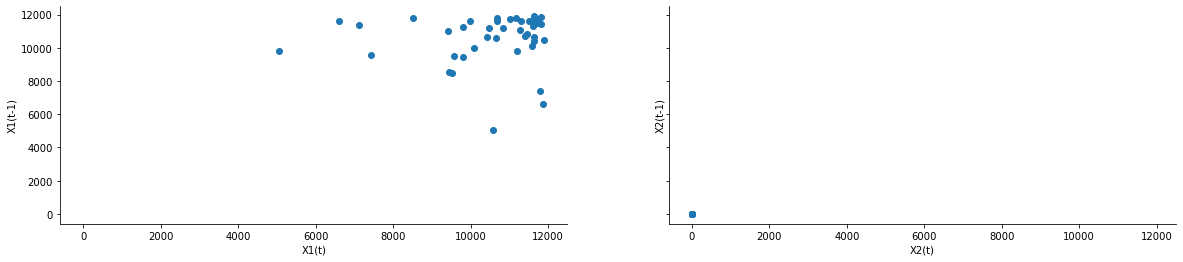

In [209]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

## 3. Forecast skill as a function of library length

In [210]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

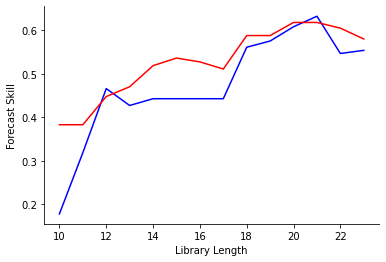

In [211]:
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()

# Tweets vs Crime

## 1. Calculate Mutual information

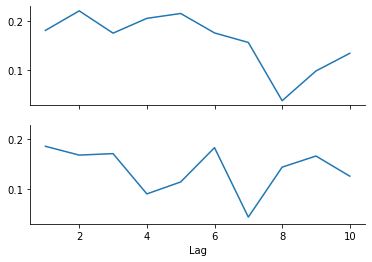

In [218]:
e3 = ccm.Embed(x3_tweets)
e2 = ccm.Embed(x2_crime)

mi3 = e3.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi3)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

## 2. Embed the time series

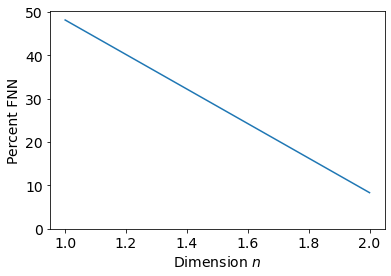

FNN embedding Dimension 2:  2


In [223]:
lag = 6
perc_FNN2, embed = FNN_n(x2, lag, plotting = True)
print('FNN embedding Dimension 2: ',embed)
X3 = e3.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

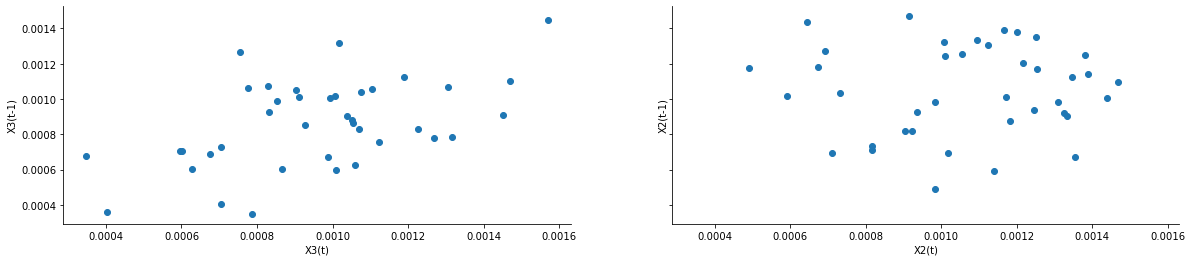

In [224]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X3[:,0],X3[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X3(t)')
ax[0].set_ylabel('X3(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

## 3. Forecast skill as a function of library length

In [225]:
#split the embedded time series
x3tr, x3te, x2tr, x2te = train_test_split(X3,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x3tr,x2tr)
x3p, x2p = CCM.predict(x3te, x2te,lib_lengths=lib_lens)

sc3,sc2 = CCM.score()

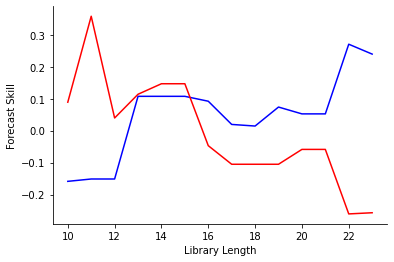

In [226]:
fig,ax = plt.subplots()
ax.plot(lib_lens,sc3,label='X3 xmap X2', color='blue') # tweet predict crime
ax.plot(lib_lens,sc2, label='X2 xmap X3', color='red') # crime predict tweet
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()